In [39]:
using ReactionMechanismSimulator
using PyPlot
using Sundials
using SciMLBase
using QuadGK

In [40]:
outdict = readinput("chem300.rms")

[11:59:23] WARNING: not removing hydrogen atom without neighbors
[11:59:23] WARNING: not removing hydrogen atom without neighbors
┌ Warning: failed to generate StokesDiffusivity model for species vacantX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CHO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2HX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species OCX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.j

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [41]:
boundarylayerspcs = outdict["gas"]["Species"]
boundarylayerrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [42]:
sitedensity = 2.292e-5; # Ag111 site density is 2.292e-9 mol/cm^2 or 2.292e-5 mol/m^2
boundarylayer = IdealDiluteSolution(boundarylayerspcs,boundarylayerrxns,solv,name="boundarylayeruid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [ ]:
# Reservoir is a 100 mL (100e-6 m^3) cell
# Proton concentration is 10^-7 mol/L (10^-4 mol/m^3)
# CO2 concentration is 0.01 mol/L (10 mol/m^3), saturation solubility ~0.03 mol/L
# AVratio in experiments is 36 m^-1 but is measured by surface area/reservoir volume
# Area of the electrode is therefore 3.6e1 m^-1 * 1e2*1e-6 m^3 = 3.6e-3 m^2 = 36 cm^2
# Assume boundary layer thickness d_bl = 1 mm or 1e-3 m
# Volume of the boundary layer V_bl = 3.6e-3 m^2 * 1e-3 m = 3.6e-6 m^3
# Actual AVratio is therefore 3.6e-3 m^2 / 3.6e-6 m^3 = 1e3 m^-1 (reciprocal of d_bl)
# Amount of sites is 2.292e-5 mol/m^2 * 1e3 m^-1 = 2.292e-2 mol/m^-3

C_proton = 1e-7*1e3;
C_co2 = 1e-2*1e3;
C_default = 1e-12;
V_res = 1000.0e-6;
AVratio = 1e3;
A_surf = 100.0e-6*36;
V_bl = A_surf/AVratio;
sites = sitedensity;

initialcondsboundarylayer = Dict(["proton"=>C_proton,
                                  "CO2"=>C_co2,
                                  "V"=>V_bl,"T"=>300,"Phi"=>0.0,"d"=>0.0]);
initialcondsreservoir = Dict(["proton"=>C_proton,
                              "CO2"=>C_co2,
                              "V"=>V_res,"T"=>300]);


# Assume voltage is -0.5 V vs. R.H.E. which equates to -0.914 V vs. S.H.E. at pH=7
initialcondssurf = Dict(["CO2X"=>0.4*sites,
        "CHO2X"=>0.1*sites,
        "CO2HX"=>0.1*sites,
        "OX"=>0.1*sites,
        "OCX"=>0.1*sites,
        "vacantX"=>0.1*sites,
        "CH2O2X"=>0.05*sites,
        "CHOX"=>0.04*sites,
        "CH2OX"=>0.01*sites,
        "A"=>A_surf,"T"=>300,"Phi"=>-1.5]);

In [44]:
domainboundarylayer, y0boundarylayer, pboundarylayer = ConstantTVDomain(phase=boundarylayer, initialconds=initialcondsboundarylayer);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [45]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainboundarylayer,
  domaincat,interfacerxns,298.15,A_surf);

In [46]:
# start with 1mm layer thickness
diffusionlayer = ConstantReservoirDiffusion(domainboundarylayer, initialcondsreservoir, A_surf, 1/AVratio);

In [47]:
interfaces = [inter, diffusionlayer];

In [48]:
@time react,y0,p = Reactor((domainboundarylayer,domaincat), (y0boundarylayer,y0cat), (0.0, 1e3), interfaces, (pboundarylayer,pcat,pinter));

  0.052389 seconds (61.60 k allocations: 139.747 MiB, 11.79% gc time)


In [49]:
@time sol = solve(react.ode,Sundials.CVODE_BDF(),abstol=1e-22,reltol=1e-8);

  5.124899 seconds (4.22 M allocations: 11.919 GiB, 13.75% gc time)


In [50]:
sol.t[end]

1000.0

In [51]:
sol.retcode

ReturnCode.Success = 1

In [52]:
ssys = SystemSimulation(sol,(domainboundarylayer,domaincat,), interfaces,p);

In [53]:
plotmolefractions(ssys.sims[1], 1e-8,tol=1e-25)
yscale("log")
xscale("log")

In [54]:
plotmolefractions(ssys.sims[2], 1e-8,tol=3e-2)
xscale("log")

In [77]:
concentrations(ssys.sims[1], 1e3)

108-element Vector{Float64}:
    0.0
    0.0
    0.0
    0.0
 2777.7746704748874
    0.027777731869113156
    0.0
    0.0
    0.0
   -1.4202635493838582e-27
    ⋮
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0

In [56]:
"""
diffusive flux to the reservoir
"""
function flux_to_reservoir(sim,t,reservoirinterface)
    cs = concentrations(sim,t)
    return reservoirinterface.A .* sim.domain.diffusivity .* (cs - reservoirinterface.c) / reservoirinterface.layer_thickness
end

"""
Integrates the flux to the reservoir and computes the concentration assuming
there is no prior concentration of that species in the reservoir
"""
function get_reservoir_concentration(sim,t,reservoirinterface,Vres)
    intg,err = quadgk(x -> flux_to_reservoir(sim,x,reservoirinterface), 0, t)
    return intg./Vres
end

get_reservoir_concentration

In [57]:
flux_to_reservoir(ssys.sims[1],1e2,diffusionlayer)

108-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.1186295429633826e-8
 1.6527130498265213e-13
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [58]:
res_cs = get_reservoir_concentration(ssys.sims[1],1e2,diffusionlayer,1.0)

108-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.1186296057560477e-6
 1.6527131868930116e-11
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [59]:
sort(res_cs)

108-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.6527131868930116e-11
 1.1186296057560477e-6

In [60]:
getfield.(ssys.sims[1].domain.phase.species,:name)

108-element Vector{String}:
 "Ar"
 "He"
 "Ne"
 "N2"
 "CO2"
 "proton"
 "H"
 "C=O"
 "O=CO"
 "H2O"
 ⋮
 "CCOCO"
 "CCCOO"
 "CCC"
 "CCOOC"
 "C=C=COO"
 "CC=COO"
 "C=CCO[O]"
 "COCOC"
 "COCCO"

In [61]:
getfield.(ssys.sims[2].domain.phase.species,:name)

192-element Vector{String}:
 "vacantX"
 "CO2X"
 "CHO2X"
 "CO2HX"
 "OCX"
 "OX"
 "CH2O2X"
 "CHOX"
 "CH2OX"
 "HOX"
 ⋮
 "O=CCCO[Pt]"
 "O=CCC[Pt]"
 "C=COOC#[Pt]"
 "C=CC=O.[Pt]"
 "C=C([Pt])C=O"
 "C=C(C=O)O[Pt]"
 "C=CC=[Pt]"
 "CC(O)O.[Pt]"
 "OC(O)C[Pt]"

In [62]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

In [63]:
# Helper function
function plotC(sim, tol, t_end, exclude)
    clf()
    xs = concentrations(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Concentration")
end

plotC (generic function with 1 method)

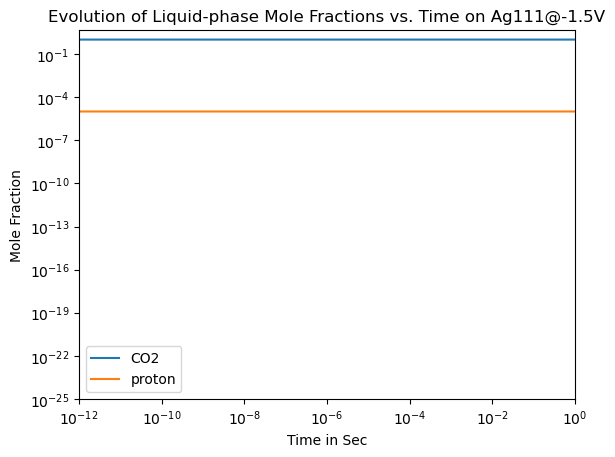

In [64]:
exclude_species = ["H2O"]
plotX(ssys.sims[1], 1e-25, 1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1)
ylim(1e-25, 5)
title("Evolution of Liquid-phase Mole Fractions vs. Time on Ag111@-1.5V")
gcf()

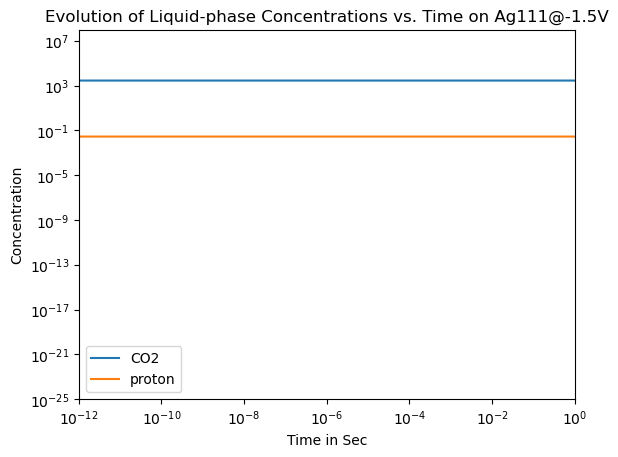

In [65]:
exclude_species = ["H2O"]
plotC(ssys.sims[1], 1e-25, 1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1)
ylim(1e-25, 1e8)
title("Evolution of Liquid-phase Concentrations vs. Time on Ag111@-1.5V")
gcf()

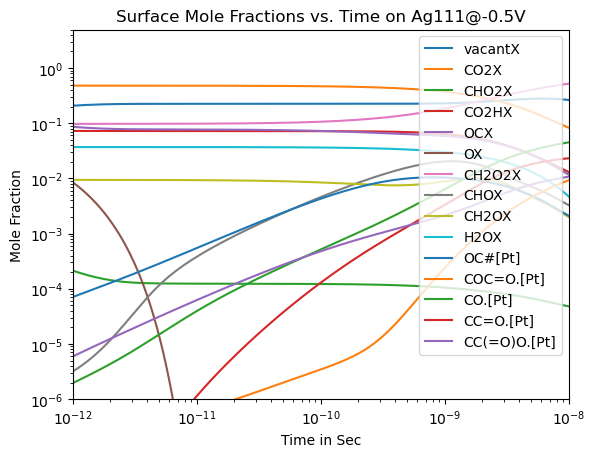

In [66]:
exclude_species = ["H2O"]
plotX(ssys.sims[2], 1e-2, 1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e-8)
ylim(1e-6, 5)
title("Surface Mole Fractions vs. Time on Ag111@-0.5V")
gcf()

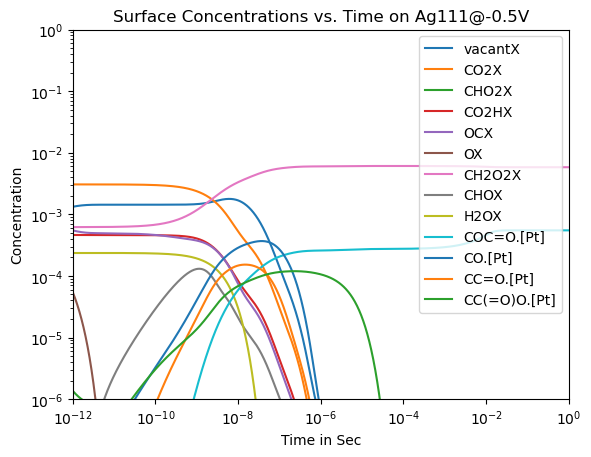

In [67]:
exclude_species = ["H2O"]
plotC(ssys.sims[2], 1e-4, 1, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1)
ylim(1e-6, 1)
title("Surface Concentrations vs. Time on Ag111@-0.5V")
gcf()

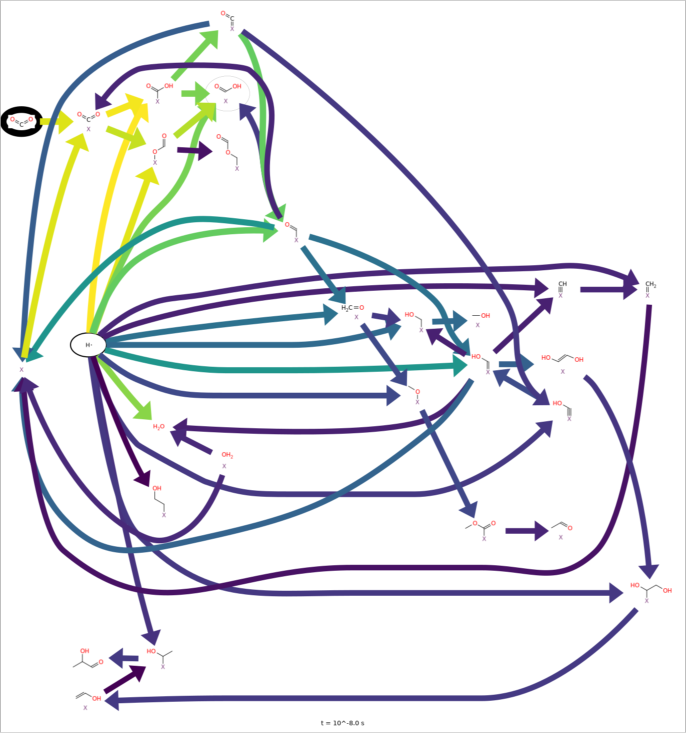

In [68]:
getfluxdiagram(ssys,1e-8;speciesratetolerance=1e-8)

In [69]:
plotrops(ssys,"CH2O2X",1e-8;N=15,tol=0.0)

In [70]:
plotrops(ssys,"CHO2X",1;N=10,tol=0.0)

In [71]:
plotrops(ssys,"CO2HX",1;N=10,tol=0.0)

In [72]:
plotrops(ssys,"OX",1;N=10,tol=0.0)

In [73]:
plotrops(ssys,"OCX",1.0e-6)

In [86]:
for (i,rxn) in enumerate(domaincat.phase.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

OX+OCX<=>vacantX+CO2X
kf = 20654.615923781494
krev = 11189.298481041604
Kc = 1.8459259048971917
CHO2X<=>CO2HX
kf = 6.700453386611787e9
krev = 154.2911945001599
Kc = 4.342732200835248e7
vacantX+CHO2X<=>OX+CHOX
kf = 7.803841747257553e9
krev = 7.148654626970559e-10
Kc = 1.0916518078541791e19
CHO2X+CHO2X<=>CO2X+CH2O2X
kf = 2.5e10
krev = 3.2154148400024995e-34
Kc = 7.775046531781437e43
CHO2X+CO2HX<=>CO2X+CH2O2X
kf = 2.5e10
krev = 8.082730550170151e-23
Kc = 3.0930141546625875e32
CHO2X+CO2HX<=>CO2X+CH2O2X
kf = 2.5e10
krev = 9.19383930722573e-19
Kc = 2.71921219901589e28
CO2HX+CO2HX<=>CO2X+CH2O2X
kf = 2.5e10
krev = 2.4457047139990357e-18
Kc = 1.0222002622353312e28
CHOX+CHO2X<=>CO2X+CH2OX
kf = 3.0109478093923404e-24
krev = 3.037156297092479e15
Kc = 9.913707148607306e-40
CHOX+CO2HX<=>CO2X+CH2OX
kf = 2.5e10
krev = 1.678437078622112e-22
Kc = 1.4894809176000438e32
CHO2X+CO2HX<=>CO2X+CH2O2X
kf = 500114.13488002896
krev = 399.6803280141717
Kc = 1251.2853393732605
CHO2X+CO2HX<=>CO2X+CH2O2X
kf = 0.00010

BoundsError: BoundsError: attempt to access 724-element Vector{Float64} at index [725]

In [78]:
for (i,rxn) in enumerate(domaincat.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

ErrorException: type ConstantTAPhiDomain has no field reactions

In [74]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

vacantX+CO2<=>CO2X
kf = 20654.615923781494
krev = 11189.298481041604
Kc = 1.8459259048971917
proton+CO2X<=>CHO2X
kf = 6.700453386611787e9
krev = 154.2911945001599
Kc = 4.342732200835248e7
proton+CO2X<=>CO2HX
kf = 7.803841747257553e9
krev = 7.148654626970559e-10
Kc = 1.0916518078541791e19
proton+CHO2X<=>CH2O2X
kf = 2.5e10
krev = 3.2154148400024995e-34
Kc = 7.775046531781437e43
proton+CO2HX<=>CH2O2X
kf = 2.5e10
krev = 8.082730550170151e-23
Kc = 3.0930141546625875e32
proton+OCX<=>CHOX
kf = 2.5e10
krev = 9.19383930722573e-19
Kc = 2.71921219901589e28
proton+CHOX<=>CH2OX
kf = 2.5e10
krev = 2.4457047139990357e-18
Kc = 1.0222002622353312e28
vacantX+vacantX+CO2<=>OX+OCX
kf = 3.0109478093923404e-24
krev = 3.037156297092479e15
Kc = 9.913707148607306e-40
OX+proton<=>HOX
kf = 2.5e10
krev = 1.678437078622112e-22
Kc = 1.4894809176000438e32
vacantX+C=O<=>CH2OX
kf = 500114.13488002896
krev = 399.6803280141717
Kc = 1251.2853393732605
proton+CHO2X<=>OX+C=O
kf = 0.00010342351299484538
krev = 3.76476421238

In [75]:
rops(ssys, "CH2O2X", 1e-12)

10962-element SparseArrays.SparseVector{Float64, Int64} with 528 stored entries:
  [47   ]  =  2767.01
  [48   ]  =  25.5592
  [49   ]  =  25.5592
  [50   ]  =  0.00155335
  [53   ]  =  25.5592
  [54   ]  =  25.5592
  [56   ]  =  6.13485e-8
           ⋮
  [10084]  =  -3.00535e-29
  [10087]  =  6.07876e-36
  [10088]  =  3.16019e-34
  [10242]  =  3.39005
  [10243]  =  1154.72
  [10253]  =  -6.63785e-5
  [10264]  =  -2.05407e-8
  [10266]  =  -1.43934e-8

In [76]:
rops(ssys, "O=CO", 1e-12)

10962-element SparseArrays.SparseVector{Float64, Int64} with 17 stored entries:
  [10253]  =  6.63785e-5
  [10254]  =  1.42545e-7
  [10255]  =  4.41868e-32
  [10256]  =  4.65077e-34
  [10265]  =  5.7985e-17
  [10268]  =  1.57587e-18
  [10273]  =  0.000235443
           ⋮
  [10310]  =  1.34103e-49
  [10352]  =  3.68017e-28
  [10540]  =  9.71107e-29
  [10555]  =  1.48134e-30
  [10835]  =  1.0098e-27
  [10865]  =  4.21006e-22
  [10867]  =  6.60825e-41
  [10908]  =  2.45269e-16